In [3]:
import pandas as pd
import requests
import zipfile
import geopandas as gpd
from io import BytesIO
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import os
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import atlite
import geopandas as gpd

### Format the datetime index of the timeseries data

In [8]:
# load availability_df csv file
availability_df = pd.read_csv('availability_df.csv')
# load demand_df csv file
demand_df = pd.read_csv('demand_df.csv')
# load forecast_df csv file
forecast_df = pd.read_csv('forecasts_df.csv')
# load powerplants_df csv file
powerplants_units = pd.read_csv('powerplant_units.csv')


In [9]:
powerplants_units.head(2)

,name,technology,fuel_type,bidding_EOM,bidding_nodal,bidding_DAM,bidding_redispatch,emission_factor,max_power,min_power,...,ramp_down,additional_cost,hot_start_cost,warm_start_cost,cold_start_cost,min_operating_time,min_down_time,unit_operator,operating_type,node
0,Unit_0,open cycle gas turbine,natural gas,naive_eom,naive_eom,flexable_eom_block,naive_redispatch,0.2052,78.302,23.4906,...,78.302,1.6,19.518453,22.648453,27.712679,1.0,1.0,Palm Power GmbH & Co. KG,Market,way/42050342-380
1,Unit_1,open cycle gas turbine,natural gas,naive_eom,naive_eom,flexable_eom_block,naive_redispatch,0.2052,57.000,17.1000,...,57.000,1.6,32.828453,54.758453,55.902679,1.0,1.0,EnBW Energie Baden-Württemberg AG,Market,way/37721677-380


In [4]:
# change datetime column of availability_df to the datetime column of demand_df
demand_df['datetime'] = availability_df['datetime']
demand_df.head()

,datetime,DE10-380,DE100-380,DE102-380,DE103-380,DE104-380,DE105-220,DE106-220,DE107-380,DE109-220,...,way/953015049-380,way/953757606-380,way/953757608-380,way/95434457-380,way/954971276-220,way/955268863-380,way/957746797-380,way/97825259-380,way/97857512-220,way/979801144-380
0,2035-01-01 00:00:00,99.709961,40.488287,28.699371,310.869688,31.033653,21.444374,48.702681,24.896827,93.334716,...,41.160904,57.906277,63.143780,19.867092,318.796402,39.112816,18.214913,32.591169,200.916193,21.446359
1,2035-01-01 01:00:00,97.499448,39.590685,28.063123,303.977885,30.345655,20.968964,47.622970,24.344879,91.265539,...,40.248390,56.622528,61.743919,19.426650,311.728868,38.245707,17.811099,31.868641,196.461996,20.970906
2,2035-01-01 02:00:00,94.840894,38.511151,27.297915,295.689206,29.518209,20.397195,46.324417,23.681058,88.776968,...,39.150922,55.078581,60.060324,18.896936,303.228840,37.202847,17.325437,30.999667,191.104993,20.399084
3,2035-01-01 03:00:00,93.663054,38.032876,26.958899,292.017006,29.151619,20.143880,45.749108,23.386960,87.674436,...,38.664702,54.394553,59.314428,18.662253,299.463005,36.740821,17.110270,30.614678,188.731637,20.145746
4,2035-01-01 04:00:00,94.088000,38.205430,27.081211,293.341878,29.283879,20.235272,45.956671,23.493066,88.072212,...,38.840123,54.641340,59.583536,18.746923,300.821659,36.907513,17.187899,30.753576,189.587907,20.237146


In [5]:
# save demand_df to csv file
demand_df.to_csv('demand_df.csv', index=False)

In [10]:
# save availability_df to csv file
forecast_df.to_csv('forecasts_df.csv', index=False)

In [3]:
# change datetime column of availability_df to the datetime column of demand_df
availability_df['datetime'] = demand_df['datetime']

In [6]:
# save availability_df to csv file
availability_df.to_csv('availability_df.csv', index=False)

### Data analysis: Demand, line capacity, powerplants capacity, storage capacity

##### 1. Create a dataframe to plot the demand vs the installed capacity (by technology)

In [40]:
# print unique values in column 'fuel_type'
print(powerplants_units['fuel_type'].unique())

['natural gas' 'hard coal' 'lignite' 'oil' 'waste' 'renewable']


In [58]:
# replace values in fuel_type which are not renewable with 'non_renewable'
stats_non=powerplants_units.copy()
stats_non['fuel_type'] = stats_non['fuel_type'].replace(['hard coal', 'natural gas', 'oil', 'lignite','waste'], 'non_renewable')

# make all technology values with fuel_type 'non_renewable' to 'non_renewable' and save it as a new dataframe
stats_non.loc[stats_non['fuel_type'] == 'non_renewable', 'technology'] = 'non_renewable'

# Create a duplicate of powerplant_units
stats_non=stats_non[['node','technology','max_power']]

# keep node and demand as a column and pivot the tech_fuel column to be columns and installed_capacity to be values
stats_non_pivot = stats_non.pivot_table(index=['node'], columns='technology', values='max_power', aggfunc='sum', fill_value=0).reset_index()

# drop the index column
stats_non_pivot.columns.name = None
stats_non_pivot.head(2)

,node,biomass,hydro,non_renewable,solar pv,wind offshore,wind onshore
0,DE1-220,0.0,0.0,0.0,0.000000,1968.182904,0.000000
1,DE10-380,0.0,0.0,0.0,430.288192,0.000000,194.034621


In [64]:
demand_df.head(2)

,datetime,DE10-380,DE100-380,DE102-380,DE103-380,DE104-380,DE105-220,DE106-220,DE107-380,DE109-220,...,way/953015049-380,way/953757606-380,way/953757608-380,way/95434457-380,way/954971276-220,way/955268863-380,way/957746797-380,way/97825259-380,way/97857512-220,way/979801144-380
0,2035-01-01 00:00:00,99.709961,40.488287,28.699371,310.869688,31.033653,21.444374,48.702681,24.896827,93.334716,...,41.160904,57.906277,63.143780,19.867092,318.796402,39.112816,18.214913,32.591169,200.916193,21.446359
1,2035-01-01 01:00:00,97.499448,39.590685,28.063123,303.977885,30.345655,20.968964,47.622970,24.344879,91.265539,...,40.248390,56.622528,61.743919,19.426650,311.728868,38.245707,17.811099,31.868641,196.461996,20.970906


In [66]:
# create a sum of the demand for each node
demand_max = demand_df.drop(columns=['datetime']).max().reset_index()
demand_max.columns = ['node', 'peak_demand']
demand_max.head(5)

,node,peak_demand
0,DE10-380,194.650494
1,DE100-380,79.039897
2,DE102-380,56.025965
3,DE103-380,606.869539
4,DE104-380,60.582873


In [59]:
# create a sum of the demand for each node
demand_sum = demand_df.drop(columns=['datetime']).sum().reset_index()
demand_sum.columns = ['node', 'demand']
demand_sum.head(2)

,node,demand
0,DE10-380,1.209846e+06
1,DE100-380,4.912708e+05


In [67]:
# merge powerplants with demand_sum on node
stats_non_pivot= pd.merge(stats_non_pivot, demand_max, on='node', how='left')

# fill na values in demand column with 0
stats_non_pivot['peak_demand'] = stats_non_pivot['peak_demand'].fillna(0)

# reorder columns to node, demand, installed_capacity, tech_fuel
stats_non_pivot=stats_non_pivot[['node','peak_demand','non_renewable','biomass','hydro','solar pv','wind onshore','wind offshore']] 
stats_non_pivot.head(2)

,node,peak_demand,non_renewable,biomass,hydro,solar pv,wind onshore,wind offshore
0,DE1-220,0.000000,0.0,0.0,0.0,0.000000,0.000000,1968.182904
1,DE10-380,194.650494,0.0,0.0,0.0,430.288192,194.034621,0.000000


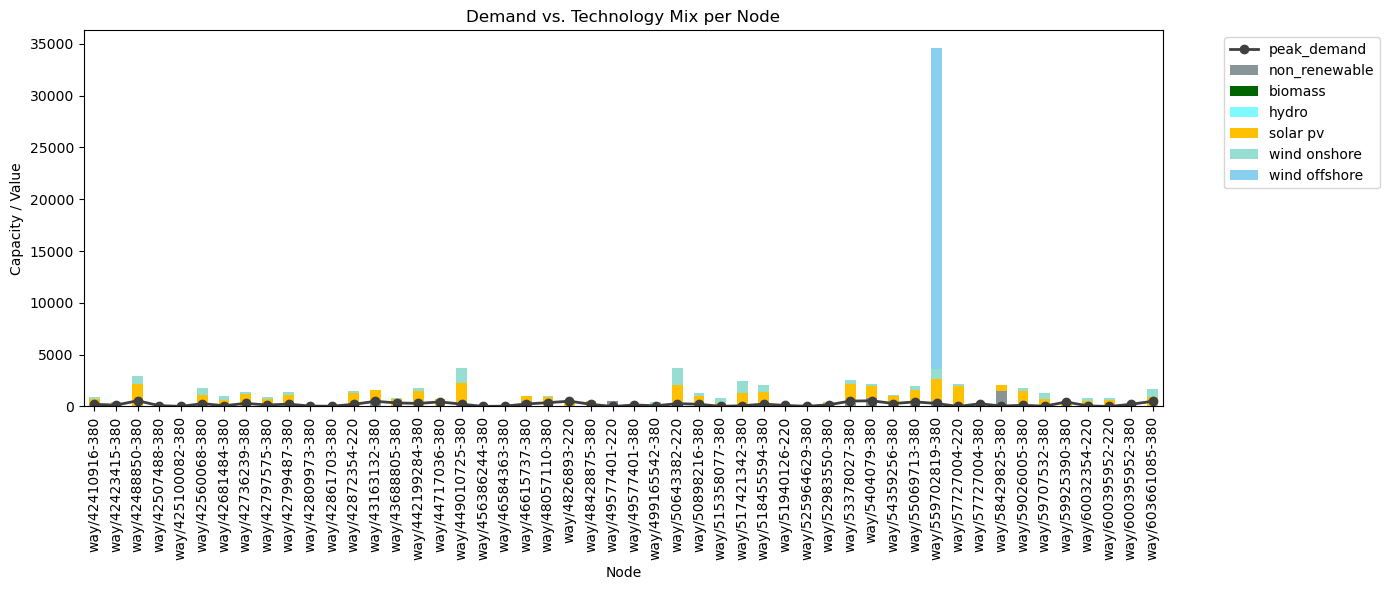

In [120]:
# Select how many nodes you want to print at a time
stats_non_pivot_plot=stats_non_pivot[500:550]

# Separate demand and other technologies
df_plot = stats_non_pivot_plot.set_index("node")
demand = df_plot["peak_demand"]

# Define hex colors
colors = {
    "solar pv": "#FFC000",       # yellow
    "wind onshore": "#96DED1",   # dark blue
    "wind offshore": "#89CFF0",  # navy blue
    "hydro": "#7DF9FF",          # light blue
    "biomass": "#006400",        # dark green
    "non_renewable": "#899499"   # dark gray (optional)
}

# Subset others
others = df_plot.drop(columns=["peak_demand"])

# Plot stacked bars with custom colors
ax = others.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6),
    color=[colors.get(col, "#D3D3D3") for col in others.columns]  # default lightgray
)

# Plot demand as dark gray line
demand.plot(ax=ax, color="#404040", linewidth=2, marker="o", label="peak_demand")

# Labels and legend
ax.set_ylabel("Capacity / Value")
ax.set_xlabel("Node")
ax.set_title("Demand vs. Technology Mix per Node")

# Rotate node names vertically
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [61]:
stats_non_pivot.to_csv('stats_non_pivot.csv', index=False)

### Line loading analysis

In [4]:
# load powerplants_df csv file
lines = pd.read_csv('lines.csv')
lines.head(2)

,name,bus0,bus1,s_nom,x,r
0,merged_relation/1208415-380-c+1,way/23380800-380,way/24478889-380,1698.103,2.305450,0.281152
1,merged_way/24532884-1-380+6,way/23380800-380,way/24479984-380,1698.103,3.387922,0.413161


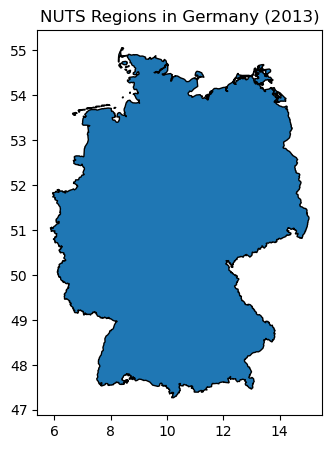

In [6]:
eu = gpd.read_file(r"C:\Users\par19744\Python_projects\ASSUME_project\ASSUME_Use_case\2035\assume\examples\inputs\example_06ab_analysis\NUTS_RG_03M_2013_4326_LEVL_0.shp.zip")
germany_nuts3 = eu[eu['CNTR_CODE'] == 'DE']
germany_nuts3.plot(figsize=(5, 5), edgecolor="black")
plt.title("NUTS Regions in Germany (2013)")
plt.show()